## Transfer Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* 필요한 라이브러리 불러오기

In [ ]:
import os
import cv2
# computer vision을 위한 라이브러리
import numpy as np
import tensorflow as tf
import random as rn
from IPython.display import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## 실제 데이터를 불러와서 학습에 적용해보기

* 학습용 반도체 공정 데이터 불러오기

*이미지 폴더 확인

In [ ]:
groups_folder_path = '/content/drive/MyDrive/CDS2(2022-2)/SEM_Dataset/RE_IPTCL_CELL_TRAIN/'
# 각 image가 존재하는 주소
categories = ['01_SPOT','20_LSAC','23_RING']
# 각 image의 종류
num_classes = len(categories)
# 전체 종류의 갯수

In [ ]:
Y = []
X = []
for idex, category in enumerate(categories):
    # 위에서 지정한 categories를 index와 함께 가져온다.
    label = [0 for i in range(num_classes)]
    # categories의 갯수만큼 0을 채운 label list를 만든다. → [0, 0, 0]
    label[idex] = 1
    # 해당 index의 label만 1로 채운다 : one-hot encoding → [1, 0, 0] or [0, 1, 0] or [0, 0, 1]
  
    image_dir = groups_folder_path + category + '/'
    # 해당하는 이미지 경로
  
    for top, dir, f in os.walk(image_dir):
        for filename in f:
        # 이미지 명
 #           print(image_dir+filename)
            url = image_dir+filename
            # 경로 + 해당 이미지
            img = cv2.imread(url)
            # 이미지로 읽어오고
            X.append(img)
            # 이미지 list에 추가
            Y.append(label)
            # label list에 추가

In [ ]:
Y[:5]

[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0]]

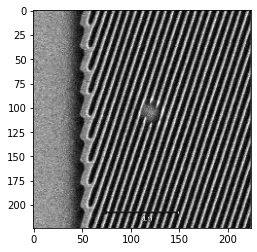

In [ ]:
plt.imshow(X[0])

In [ ]:
X[0].shape

(224, 224, 3)

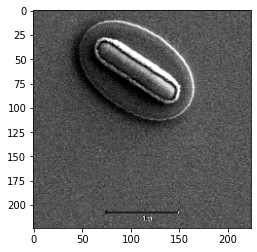

In [ ]:
plt.imshow(X[-1])

In [ ]:
X[-1].shape

(224, 224, 3)

* 테스트 데이터 : 동일하게 작업

In [ ]:
groups_folder_path_test = '/content/drive/MyDrive/CDS2(2022-2)/SEM_Dataset/RE_IPTCL_CELL_TEST/'
# 각 image가 존재하는 주소
categories_test = ['01_SPOT','20_LSAC','23_RING']
# 각 image의 종류
num_classes_test = len(categories_test)
# 전체 종류의 갯수

In [ ]:
X_test = []
Y_test = []
  
for idex, category in enumerate(categories_test):
    label = [0 for i in range(num_classes_test)]
    label[idex] = 1
    image_dir = groups_folder_path_test + category + '/'
  
    for top, dir, f in os.walk(image_dir):
        for filename in f:
      #      print(image_dir+filename)
            url_test = image_dir+filename
            img_test = cv2.imread(url_test)
            X_test.append(img_test)
            Y_test.append(label)

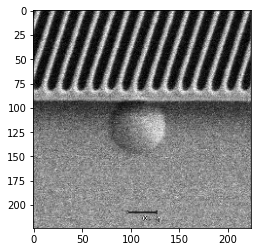

In [ ]:
plt.imshow(X_test[0])

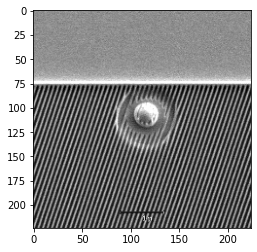

In [ ]:
plt.imshow(X_test[-1])

* 학습용 & 테스트용 데이터 분리

In [ ]:
len(X), len(Y)

(804, 804)

In [ ]:
X = np.array(X)
# np.array 형태로 변경
Y = np.array(Y)

In [ ]:
test_images = np.array(X_test)
test_oh_labels = np.array(Y_test)

In [ ]:
tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(X, Y, test_size=0.30, random_state=42)

In [ ]:
print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

(562, 224, 224, 3) (562, 3) (242, 224, 224, 3) (242, 3) (303, 224, 224, 3) (303, 3)


In [ ]:
print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

(562, 224, 224, 3) (562, 3) (242, 224, 224, 3) (242, 3) (303, 224, 224, 3) (303, 3)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
  #  rotation_range=20,
  #  zoom_range=(0.7, 0.9),
  #  horizontal_flip=True,
  #  vertical_flip=True,
    rescale=1/255.0
)

valid_generator = ImageDataGenerator(rescale=1/255.0)

In [ ]:
BATCH_SIZE = 8

In [ ]:
flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=True)

## VGG16에 학습

### Transfer Learning

In [ ]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/03/tr.png')

Output hidden; open in https://colab.research.google.com to view.

* 사전 구현된 VGG16 Model 불러오기

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 8

In [ ]:
len(categories)

3

* pretrained model 불러오기 : 최종출력은 custom data의 class 갯수만큼 출력

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False) # weights='imagenet'
bm_output = base_model.output


x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.5)(x)
x = Dense(200, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5)(x)
output = Dense(3, activation='softmax', name='output')(x)
# 최종 출력은 우리가 구분하려는 class의 갯수와 같아야한다. 

model = Model(inputs=base_model.input, outputs=output)
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
def create_model(verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model =  VGG16(input_tensor=input_tensor, weights=None , include_top=False) # , weights='imagenet'
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    x = Dropout(rate=0.5)(x)
    x = Dense(200, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.5)(x)
    output = Dense(3, activation='softmax', name='output')(x)
    # 최종 출력은 우리가 구분하려는 class의 갯수와 같아야한다. 
      
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
        
    return model

In [ ]:
vgg_model = create_model(verbose=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

* 학습

In [ ]:
history = vgg_model.fit(flow_tr_gen, epochs=20, 
                    validation_data=flow_val_gen,
                    batch_size=BATCH_SIZE,
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/20
71/71 [==============================] - 29s 203ms/step - loss: 1.0312 - accuracy: 0.4359 - val_loss: 0.9638 - val_accuracy: 0.5868 - lr: 1.0000e-04
Epoch 2/20
71/71 [==============================] - 12s 176ms/step - loss: 0.9500 - accuracy: 0.5658 - val_loss: 0.7697 - val_accuracy: 0.6033 - lr: 1.0000e-04
Epoch 3/20
71/71 [==============================] - 13s 178ms/step - loss: 0.8548 - accuracy: 0.5801 - val_loss: 0.7314 - val_accuracy: 0.6198 - lr: 1.0000e-04
Epoch 4/20
71/71 [==============================] - 12s 174ms/step - loss: 0.7717 - accuracy: 0.5943 - val_loss: 0.6596 - val_accuracy: 0.6074 - lr: 1.0000e-04
Epoch 5/20
71/71 [==============================] - 12s 172ms/step - loss: 0.7537 - accuracy: 0.6014 - val_loss: 0.6416 - val_accuracy: 0.6157 - lr: 1.0000e-04
Epoch 6/20
71/71 [==============================] - 12s 171ms/step - loss: 0.7352 - accuracy: 0.5890 - val_loss: 0.6607 - val_accuracy: 0.6116 - lr: 1.0000e-04
Epoch 7/20
71/71 [======================

실행 구간 : shift + enter


In [ ]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
vgg_model.evaluate(flow_test_gen)

38/38 [==============================] - 3s 89ms/step - loss: 0.5471 - accuracy: 0.7426


[0.5470902919769287, 0.7425742745399475]

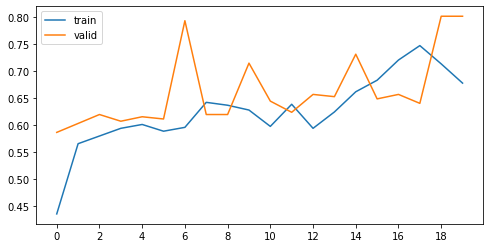

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

### fine tunning

실행 구간 : shift + enter

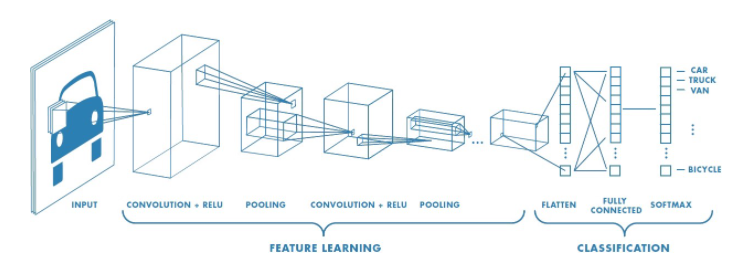

In [ ]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/02/f_e.png')

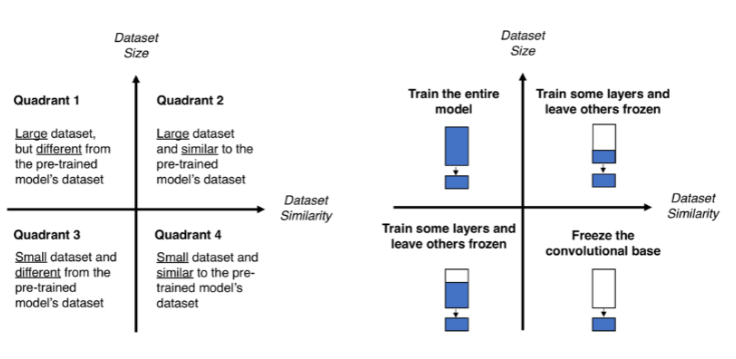

In [ ]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/02/transfer01.png')

* 1) image net 가중치로 초기화

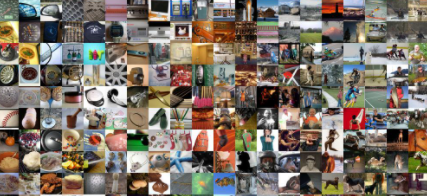

In [ ]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/02/imgnet.png')

In [ ]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False) # weights='imagenet'
bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.5)(x)
x = Dense(200, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5)(x)
output = Dense(3, activation='softmax', name='output')(x)
# 최종 출력은 우리가 구분하려는 class의 갯수와 같아야한다. 

#model = Model(inputs=input_tensor, outputs=output)
model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [ ]:
history = model.fit(flow_tr_gen, epochs=20, 
                    validation_data=flow_val_gen,
                    batch_size=BATCH_SIZE,
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/20
71/71 [==============================] - 14s 177ms/step - loss: 1.3388 - accuracy: 0.3505 - val_loss: 1.0950 - val_accuracy: 0.3430 - lr: 0.0010
Epoch 2/20
71/71 [==============================] - 12s 174ms/step - loss: 1.1043 - accuracy: 0.3523 - val_loss: 1.1000 - val_accuracy: 0.3140 - lr: 0.0010
Epoch 3/20
71/71 [==============================] - 12s 168ms/step - loss: 1.0988 - accuracy: 0.3434 - val_loss: 1.0984 - val_accuracy: 0.3140 - lr: 0.0010
Epoch 4/20
71/71 [==============================] - 12s 167ms/step - loss: 1.1053 - accuracy: 0.3505 - val_loss: 1.5876 - val_accuracy: 0.3430 - lr: 0.0010
Epoch 5/20
71/71 [==============================] - 12s 168ms/step - loss: 1.4696 - accuracy: 0.3310 - val_loss: 1.0985 - val_accuracy: 0.3140 - lr: 0.0010
Epoch 6/20
71/71 [==============================] - ETA: 0s - loss: 1.1101 - accuracy: 0.3256
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
71/71 [==============================] - 12s 167m

In [ ]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model.evaluate(flow_test_gen)

38/38 [==============================] - 2s 58ms/step - loss: 0.7197 - accuracy: 0.5809


[0.7196808457374573, 0.5808581113815308]

* 2) Layer 갯수로 조정

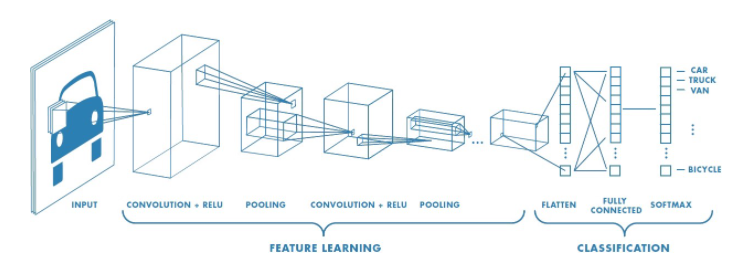

In [ ]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/02/f_e.png')

In [ ]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False) # weights='imagenet'
bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.5)(x)
x = Dense(200, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5)(x)
output = Dense(3, activation='softmax', name='output')(x)
# 최종 출력은 우리가 구분하려는 class의 갯수와 같아야한다. 

#model = Model(inputs=input_tensor, outputs=output)
model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
len(model.layers)

24

In [ ]:
model.layers

In [ ]:
model.layers[:16]

In [ ]:
fine_tune_at = 16
# 16번째 layer까지의 학습된 가중치를 사용

for layer in model.layers[:fine_tune_at]:
    layer.trainable =  False

* layer 확인

In [ ]:
display_layers = [(layer, layer.name, layer.trainable) for layer in model.layers]

pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_4,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [ ]:
history = model.fit(flow_tr_gen, epochs=20, 
                    validation_data=flow_val_gen,
                    batch_size=BATCH_SIZE,
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/20
71/71 [==============================] - 7s 86ms/step - loss: 0.8711 - accuracy: 0.6246 - val_loss: 0.3806 - val_accuracy: 0.8430 - lr: 1.0000e-04
Epoch 2/20
71/71 [==============================] - 6s 86ms/step - loss: 0.5298 - accuracy: 0.7829 - val_loss: 0.2363 - val_accuracy: 0.9215 - lr: 1.0000e-04
Epoch 3/20
71/71 [==============================] - 6s 83ms/step - loss: 0.3964 - accuracy: 0.8203 - val_loss: 0.2306 - val_accuracy: 0.9174 - lr: 1.0000e-04
Epoch 4/20
71/71 [==============================] - 6s 84ms/step - loss: 0.3309 - accuracy: 0.8808 - val_loss: 0.2634 - val_accuracy: 0.8802 - lr: 1.0000e-04
Epoch 5/20
71/71 [==============================] - 6s 84ms/step - loss: 0.3062 - accuracy: 0.8897 - val_loss: 0.1751 - val_accuracy: 0.9215 - lr: 1.0000e-04
Epoch 6/20
71/71 [==============================] - 6s 84ms/step - loss: 0.2884 - accuracy: 0.8950 - val_loss: 0.1627 - val_accuracy: 0.9421 - lr: 1.0000e-04
Epoch 7/20
71/71 [==============================] - 

In [ ]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model.evaluate(flow_test_gen)

38/38 [==============================] - 2s 58ms/step - loss: 0.2472 - accuracy: 0.9241


[0.2472245842218399, 0.9240924119949341]

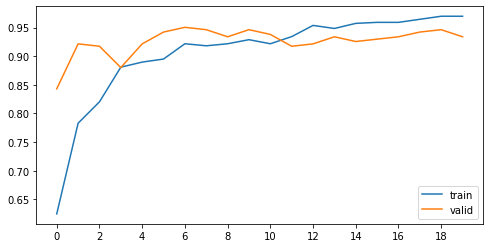

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

* 다른 Model 사용해보기
    - EfficientNetB0<br>
      - 이미지 크기, 모델의 깊이, 너비를 강화학습을 통해서 효율적으로 찾음
      - 해상도에 따라 B0~B7
      

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
base_model = EfficientNetB0(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False) # weights='imagenet'
bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.5)(x)
x = Dense(200, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5)(x)
output = Dense(3, activation='softmax', name='output')(x)
# 최종 출력은 우리가 구분하려는 class의 갯수와 같아야한다. 

#model = Model(inputs=input_tensor, outputs=output)
model = Model(inputs=base_model.input, outputs=output)
model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding

In [ ]:
fine_tune_at = 19
# 19번째 layer까지의 학습된 가중치를 사용

for layer in model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
display_layers = [(layer, layer.name, layer.trainable) for layer in model.layers]

pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_5,False
1,<keras.layers.preprocessing.image_preprocessin...,rescaling,False
2,<keras.layers.preprocessing.normalization.Norm...,normalization,False
3,<keras.layers.convolutional.ZeroPadding2D obje...,stem_conv_pad,False
4,<keras.layers.convolutional.Conv2D object at 0...,stem_conv,False
...,...,...,...
237,<keras.layers.pooling.GlobalAveragePooling2D o...,global_average_pooling2d_4,True
238,<keras.layers.core.dropout.Dropout object at 0...,dropout_8,True
239,<keras.layers.core.dense.Dense object at 0x7f5...,fc1,True
240,<keras.layers.core.dropout.Dropout object at 0...,dropout_9,True


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [ ]:
history = model.fit(flow_tr_gen, epochs=20, 
                    validation_data=flow_val_gen,
                    batch_size=BATCH_SIZE,
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/20
71/71 [==============================] - 19s 109ms/step - loss: 0.8999 - accuracy: 0.5836 - val_loss: 1.0958 - val_accuracy: 0.4463 - lr: 1.0000e-04
Epoch 2/20
71/71 [==============================] - 6s 79ms/step - loss: 0.6282 - accuracy: 0.7544 - val_loss: 1.1287 - val_accuracy: 0.2066 - lr: 1.0000e-04
Epoch 3/20
71/71 [==============================] - 6s 79ms/step - loss: 0.4412 - accuracy: 0.8381 - val_loss: 3.2335 - val_accuracy: 0.2438 - lr: 1.0000e-04
Epoch 4/20
71/71 [==============================] - 6s 80ms/step - loss: 0.3967 - accuracy: 0.8399 - val_loss: 16.4264 - val_accuracy: 0.3099 - lr: 1.0000e-04
Epoch 5/20
71/71 [==============================] - 6s 81ms/step - loss: 0.3673 - accuracy: 0.8523 - val_loss: 39.4649 - val_accuracy: 0.3802 - lr: 1.0000e-04
Epoch 6/20
71/71 [==============================] - ETA: 0s - loss: 0.3059 - accuracy: 0.8897
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
71/71 [============================

In [ ]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model.evaluate(flow_test_gen)

38/38 [==============================] - 2s 39ms/step - loss: 0.2375 - accuracy: 0.9142


[0.23750129342079163, 0.9141914248466492]

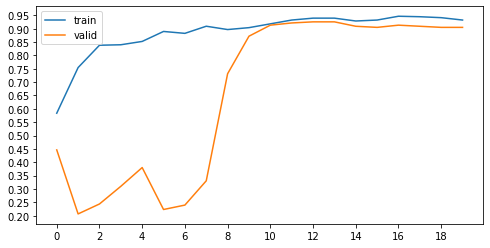

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)